# Preprocessing

## Preparation

### Loading libraries

In [1]:
import mne
import os
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mne.channels import make_standard_montage
from mne import pick_types
from mne.decoding import CSP


### Initializing data and event files

In [4]:
dir_address = "../../grasp-and-lift-eeg-detection"

# Training data
training_files = os.listdir(f"{dir_address}/train") # subj1_series1_data.csv
# Subsetting training files
training_files_events = [file for file in training_files if re.search("events",file)]
training_files_data = [file for file in training_files if re.search("data",file)]

# Testing data 
testing_files = os.listdir(f"{dir_address}/test")
# Subsetting testing files
testing_files_events = [file for file in testing_files if re.search("events",file)]
testing_files_data = [file for file in testing_files if re.search("data",file)]

34 events found
Event IDs: [1]


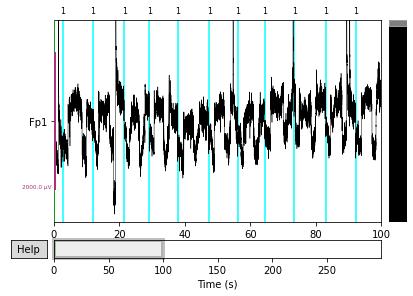

In [12]:
def get_subject_files(subject,dir_address,test=False,series=None):
    '''
    dir_address: refers to the folder which contains the training and testing subfolders
    subject: refers to the subject number to return
    test: refers to whether you want training or testing data
            If no opton is given, then the training files are automatically chosen
    series: refers to the specific series that you want to access
            If no series is given, returns all subject files
    '''
    if test:
        subfolder = "test"
    else:
        subfolder = "train"
    files = os.listdir(f"{dir_address}/{subfolder}")
    data  = np.sort([file for file in files if re.search(f"subj{subject}_",file) and re.search(f"data",file)]).tolist()
    events = np.sort([file for file in files if re.search(f"subj{subject}_",file) and re.search(f"event",file)]).tolist()
    if series:
        data = [file for file in data if re.search(f"_series{series}_",file)]
        events = [file for file in events if re.search(f"_series{series}_",file)]

    return data, events

def create_raw(datafile,dir_address,test=False,sfreq=500):
    '''
    datafile: refers to the address of the file you are trying to access
    dir_address: refers to the address of the directory you are trying to access (directory contains file)
    test: if True, returns testing files, else looks for training files
    sfreq: refers to the sampling frequency, if none given, 500 Hz
    '''
    if test:
        subfolder = "test"
    else:
        subfolder = "train"
    file_address = f"{dir_address}/{subfolder}/{datafile}"
    chnames = pd.read_csv(f"{dir_address}/{subfolder}/{datafile}").columns[1:].to_list()
    info = mne.create_info(chnames,sfreq,ch_types=['eeg']*len(chnames))
    samples = 1e-6*np.genfromtxt(file_address,delimiter=",")[1:,1:].T
    raw = mne.io.RawArray(samples,info,verbose="critical")
    return raw, chnames

def add_events(raw,event,dir_address,test=False):
    '''
    raw: raw object from mne tools
    event: the event file to add events from
    dir_address: the directory from which to obtain the event
    test: if False, returns training files. If True, returns testing files.
    '''
    if test:
        subfolder = "test"
    else:
        subfolder = "train"
    event_names = pd.read_csv(f"{dir_address}/train/{event}").columns[1:].to_list()
    samples = np.genfromtxt(f"{dir_address}/{subfolder}/{event}",delimiter=",")[1:,1:].T
    num_events = samples.shape[0]
    for i in range(num_events):
        event_data = samples[i]
        sample_numbers = list(range(0,len(event_data)))
        event_name = event_names[i][0:15]
        event_samples = np.vstack((sample_numbers,[np.random.randint(100) for i in range(len(sample_numbers))],event_data)).T
        info = mne.create_info([event_name], raw.info['sfreq'], ['stim'],verbose="critical")
        stim_data = np.zeros((1, raw.n_times))
        stim_raw = mne.io.RawArray(stim_data, info,verbose="critical")
        raw.add_channels([stim_raw], force_update_info=True)
        raw.add_events(events=event_samples,stim_channel = event_name)
    return list(map(lambda x: x[0:15],event_names))

data, events = get_subject_files(2,dir_address,series=8)
raw ,ch_names= create_raw(data[0],dir_address) # example 
event_names = add_events(raw,events[0],dir_address)

scalings = {"eeg":10e-4}  # Could also pass a dictionary with some value == 'auto'

# Don't make changes to this line of code
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# To view different events, pass in an event name into the stim_channel parameters -
# select this from the event_names variable
events_mne = mne.find_events(raw, stim_channel=[event_names[0]]) # e.g. Here I'm looking at the HandStart event


plt.figure()


# static plot - cannot interact
%matplotlib inline
raw.plot(events=events_mne,n_channels=1,duration=100,scalings=scalings,verbose=None); plt.show()

# interactive plot - can interact
# %matplotlib qt
# raw.plot(events=events_mne,n_channels=1,duration=100,scalings=scalings,verbose=False); plt.show()


In [10]:
data, events = get_subject_files(2,dir_address,series=8)
raw ,ch_names= create_raw(data[0],dir_address) # example 

## Spectral Content Analysis

Effective window size : 4.096 (s)


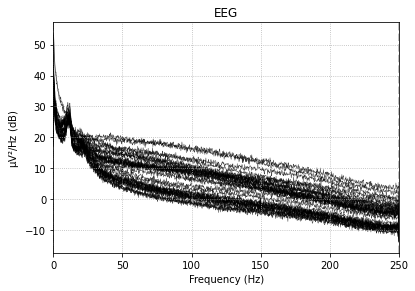

In [4]:
raw = raw.pick_types(meg=False, eeg=True, eog=False)
raw.plot_psd(spatial_colors=False)
plt.show()

### Making Montage

In [5]:
# montage = make_standard_montage('standard_1005')
# raw.set_montage(montage)
# raw.plot()
# plt.show()

## Topographical Analysis (after identifying bad channels)

In [6]:
# from mne.time_frequency import psd_welch
# raw = raw.pick_types(meg=False, eeg=True, eog=False)
# raw = raw.set_eeg_reference()
# raw.plot()
# spectra, freqs = psd_welch(raw, fmin=1, fmax=40, tmin=0, tmax=250,
#                            n_overlap=150, n_fft=300)

## Filtering 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



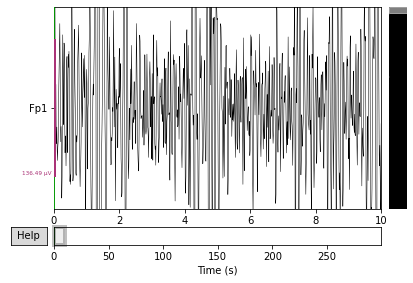

Effective window size : 4.096 (s)


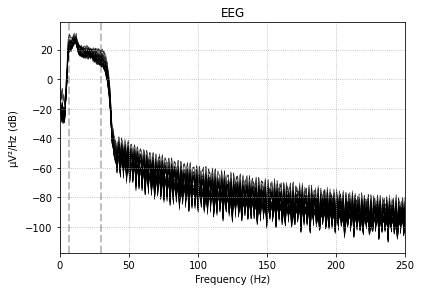

In [7]:
raw_mne = raw # save changes
raw_mne = raw_mne.filter(l_freq = 7, h_freq= 30)

raw_mne.plot(n_channels=1,scalings="auto")
data, times = raw_mne["Fp1"]
raw_mne = raw_mne.pick_types(meg=False, eeg=True, eog=False)
raw_mne.plot_psd(spatial_colors=False)
plt.show()

## Filtering (using butter this time)

Effective window size : 4.096 (s)


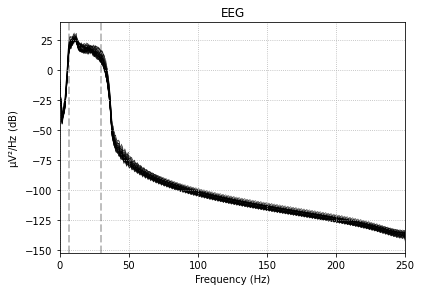

In [8]:
from scipy.signal import butter, lfilter, convolve, boxcar
raw_scipy = raw
freqs = [7,30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')
picks = pick_types(raw_scipy.info,eeg=True)
raw_scipy._data[picks] = np.array([lfilter(b,a,raw_scipy._data[i]) for i in picks])
raw_scipy = raw_scipy.pick_types(meg=False, eeg=True, eog=False)
raw_scipy.plot_psd(spatial_colors=False)
plt.show()

## CSP


In [9]:
nfilters = 4
csp = CSP(n_components=nfilters, reg='lws')